# 필요 패키지 임포트

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import torch
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import pickle
warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')

# Random Seed 고정

In [ ]:
random_seed = 1004

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 하이퍼 파라미터 설정

In [ ]:
batch_size = 64
learning_rate = 2e-4
epochs = 40

# 데이터 로드

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
)
trainset = datasets.CIFAR10(root='./data/', train=True, download=True, transform=transform, target_transform=None)
testset = datasets.CIFAR10(root='./data/', train=False, download=True, transform=transform, target_transform=None)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(trainset.__len__())
print(testset.__len__())

img1, label1 = trainset.__getitem__(0)
img2, label2 = trainset.__getitem__(0)

print(img1.shape, label1)
print(img2.shape, label2)

50000
10000
torch.Size([3, 32, 32]) 6
torch.Size([3, 32, 32]) 6


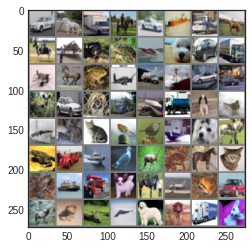

  car horse truck horse   car  ship   car horse horse plane   dog  frog  ship   dog   car truck plane horse  frog plane truck  ship   car   car  deer   car   dog truck plane truck   dog  bird  ship   cat   cat  bird  bird  ship   dog horse  frog truck  ship  bird  deer  frog horse   cat  frog  ship truck   dog horse plane  frog   car  deer   dog  deer plane   dog  bird truck   dog


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
dataiter.next()[0].shape

torch.Size([64, 3, 32, 32])

# 모델링

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            )

        self.fc = nn.Sequential(
            nn.Linear(in_features=512 * 4 * 4, out_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=10)
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc(out)

        return out

In [ ]:
class DropoutCNN(BasicCNN):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=512 * 4 * 4, out_features=200),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=200, out_features=10)
        )

In [ ]:
class BatchNormCNN(BasicCNN):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

In [ ]:
class BatchNormDropoutCNN(BatchNormCNN):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=512 * 4 * 4, out_features=200),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=200, out_features=10)
        )

In [ ]:
class XavierBasicCNN(BasicCNN):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=512 * 4 * 4, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=10)
        init.xavier_uniform_(self.linear1.weight)
        init.xavier_uniform_(self.linear2.weight)

        self.fc = nn.Sequential(
            self.linear1,
            nn.ReLU(),
            self.linear2
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc(out)

        return out

In [ ]:
class HeBasicCNN(BasicCNN):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=512 * 4 * 4, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=10)
        init.kaiming_uniform_(self.linear1.weight)
        init.kaiming_uniform_(self.linear2.weight)

        self.fc = nn.Sequential(
            self.linear1,
            nn.ReLU(),
            self.linear2
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc(out)

        return out

In [ ]:
class XavierBatchNormDropoutCNN(BatchNormCNN):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=512 * 4 * 4, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=10)
        init.xavier_uniform_(self.linear1.weight)
        init.xavier_uniform_(self.linear2.weight)

        self.fc = nn.Sequential(
            self.linear1,
            nn.ReLU(),
            nn.Dropout(0.5),
            self.linear2
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc(out)

        return out

# 개별 모델 학습/평가

In [ ]:
model = XavierBatchNormDropoutCNN().to(device)
model

XavierBatchNormDropoutCNN(
  (layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1,

In [ ]:
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_batch = trainloader.__len__()

In [ ]:
model.train()
train_loss_history = []

for epoch in range(epochs):
    average_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        X_train = images.to(device)
        y_train = labels.to(device)

        optimizer.zero_grad()
        logits = model(X_train)
        loss = loss_func(logits, y_train)
        loss.backward()
        optimizer.step()

        average_loss += loss.item() / total_batch
    train_loss_history.append(average_loss)
    print(f'[epoch {epoch+1}] loss = {average_loss}')

[epoch 1] loss = 1.6578627325661213
[epoch 2] loss = 1.2799157797908658
[epoch 3] loss = 1.0956098586893264
[epoch 4] loss = 0.9675484002781284
[epoch 5] loss = 0.8732479564587994
[epoch 6] loss = 0.7848590259057453
[epoch 7] loss = 0.7174357146444457
[epoch 8] loss = 0.6481256934500533
[epoch 9] loss = 0.5843569831338342
[epoch 10] loss = 0.5316245615596805
[epoch 11] loss = 0.48845719632891776
[epoch 12] loss = 0.44131241023311535
[epoch 13] loss = 0.39700642997034075
[epoch 14] loss = 0.3644879238820715
[epoch 15] loss = 0.3322763178931615
[epoch 16] loss = 0.3058592081451539
[epoch 17] loss = 0.284088913604102
[epoch 18] loss = 0.2582982690401482
[epoch 19] loss = 0.24245159393808424
[epoch 20] loss = 0.23109883623300195
[epoch 21] loss = 0.20606383447572293
[epoch 22] loss = 0.1990569751619071
[epoch 23] loss = 0.18876130448203535
[epoch 24] loss = 0.18152363450479886
[epoch 25] loss = 0.17498821854858487
[epoch 26] loss = 0.1613032950968427
[epoch 27] loss = 0.15852313686434125
[

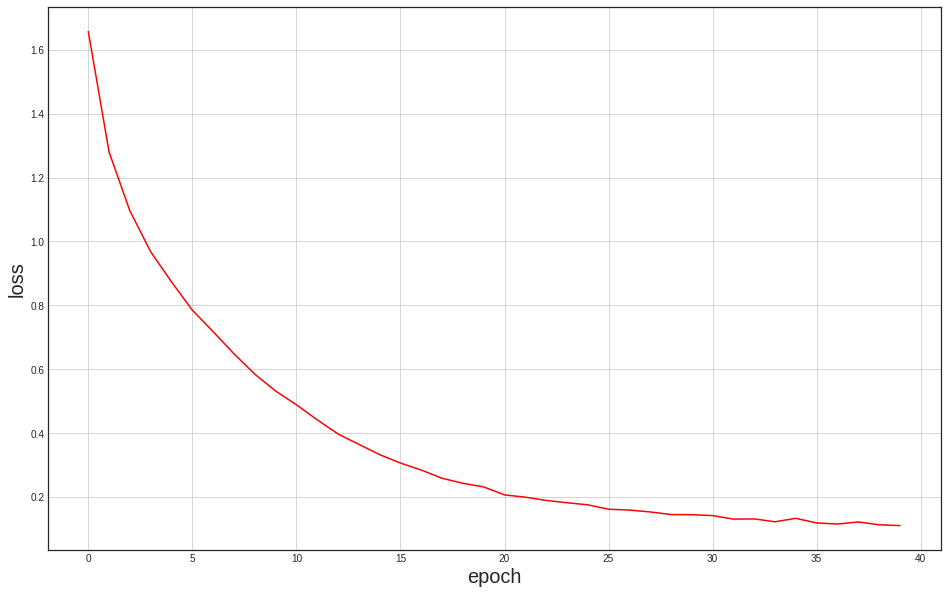

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(range(epochs), train_loss_history, color='red')
plt.grid()
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
model.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        X_test = images.to(device)
        y_test = labels.to(device)
        logits = model(X_test)
        correct += (torch.argmax(logits, dim=1) == y_test).sum()
        total += y_test.size(0)
        
print(f'Accuracy : {(correct / total) * 100:.3f}%')

Accuracy : 82.141%


# 복수 모델 학습/평가

In [ ]:
models = [BasicCNN(), DropoutCNN(), BatchNormCNN(), BatchNormDropoutCNN(), XavierBasicCNN(), XavierBatchNormDropoutCNN(), HeBasicCNN()]
models_name = ['BasicCNN', 'DropoutCNN', 'BatchNormCNN', 'BatchNormDropoutCNN', 'XavierBasicCNN','XavierBatchNormDropoutCNN', 'HeBasicCNN']
models_loss_history = []
models_accuracy = []

for model in models:
    print('====================================Model Info====================================')
    print(model)
    print('==================================================================================')

    model = model.to(device)
    loss_func = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    total_batch = trainloader.__len__()

    model.train()
    train_loss_history = []

    for epoch in range(epochs):
        average_loss = 0.0
        for i, (images, labels) in enumerate(trainloader):
            X_train = images.to(device)
            y_train = labels.to(device)

            optimizer.zero_grad()
            logits = model(X_train)
            loss = loss_func(logits, y_train)
            loss.backward()
            optimizer.step()

            average_loss += loss.item() / total_batch
        train_loss_history.append(average_loss)
        print(f'[epoch {epoch+1}] loss = {average_loss}\n')
    models_loss_history.append(train_loss_history)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            X_test = images.to(device)
            y_test = labels.to(device)
            logits = model(X_test)
            correct += (torch.argmax(logits, dim=1) == y_test).sum()
            total += y_test.size(0)
    
    accuracy = (correct / total) * 100
    print(f'Accuracy : {accuracy:.3f}%')
    models_accuracy.append(accuracy)

====================================Model Info====================================
BasicCNN(
  (layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=8192, out_features=200, b

In [ ]:
for model, loss_history, accuracy in zip(models_name, models_loss_history, models_accuracy):
    print(f'model : {model}')
    print(f'accuracy : {accuracy}')
    print(f'loss history : {loss_history}')
    print('')

model : BasicCNN
accuracy : 75.22035217285156
loss history : [1.636364192419258, 1.2239830420661375, 1.0308331300751363, 0.894937889753017, 0.7775197575553281, 0.6833057633282734, 0.595162745741662, 0.5143008024530737, 0.4369806581666928, 0.3623687972561498, 0.2853976474280695, 0.2150531163183966, 0.15349113105029533, 0.11808804207613811, 0.08719568296064943, 0.07417850772028592, 0.05704501501723367, 0.05747061989821074, 0.05451709996979254, 0.04652696943134742]

model : DropoutCNN
accuracy : 78.03485107421875
loss history : [1.7672360364667286, 1.393817703641484, 1.221410413405042, 1.0955676651642063, 0.9923751533565703, 0.9114835267640853, 0.8340142828325308, 0.7744908099672095, 0.7147615609950516, 0.6545748274091263, 0.5979813311759394, 0.5374403322704623, 0.48679963649082447, 0.4374190434985213, 0.39455236063342364, 0.3434000808492821, 0.30514684798393893, 0.26777223946953566, 0.23990244949272266, 0.21097995518264367]

model : BatchNormCNN
accuracy : 78.37539672851562
loss history 

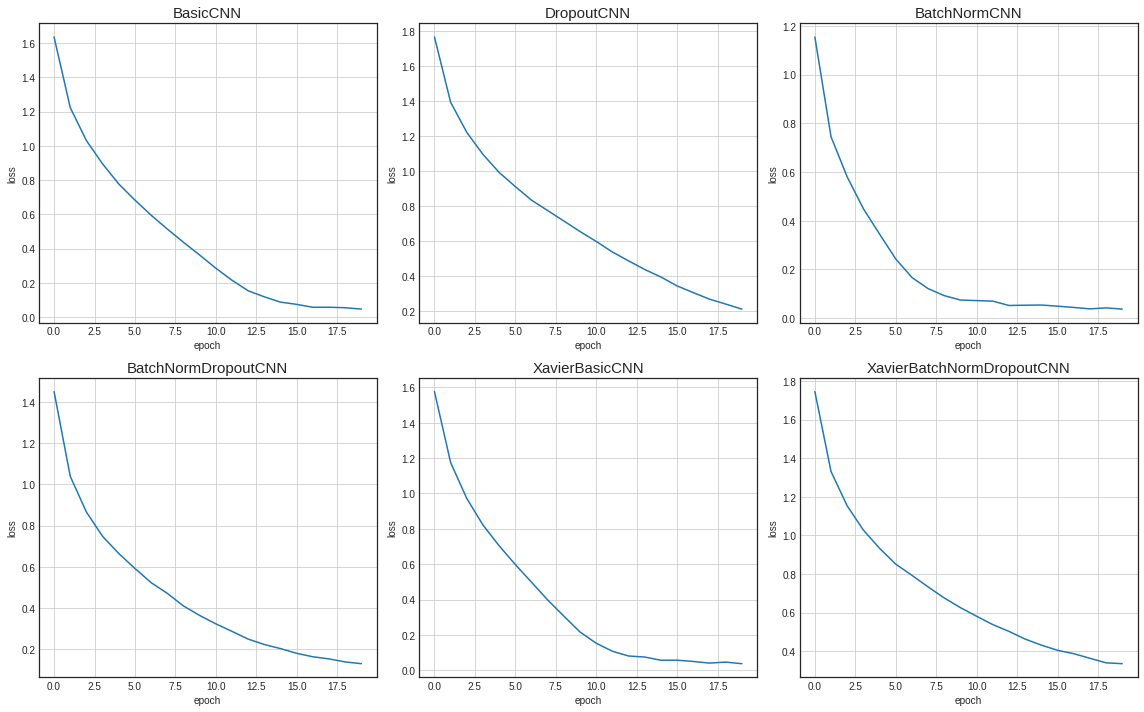

In [ ]:
plt.figure(figsize=(16, 10))

n = 1
for model, loss_history in zip(models_name, models_loss_history):
    ax = plt.subplot(2, 3, n)
    plt.title(model, fontsize=15)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    ax.plot(range(epochs), loss_history)
    n += 1
plt.tight_layout()
plt.show()

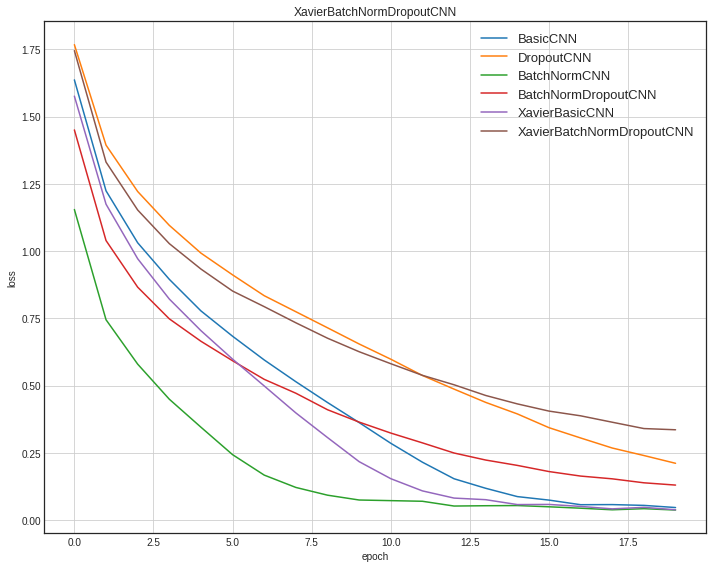

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Models Loss Curve', fontsize=15)
for model, loss_history in zip(models_name, models_loss_history):
    plt.title(model)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(epochs), loss_history, label=model)
plt.grid()
plt.legend(loc='upper right', fontsize=13)
plt.tight_layout()
plt.show()

# 하이퍼파라미터 종류에 따른 자동 학습/평가

In [ ]:
def combination(learning_rate, batch_size, epoch):
    comb_ls = []
    comb_info = {}

    for lr in learning_rate:
        for b in batch_size:
            for e in epoch:
                comb_info['learning_rate'] = lr
                comb_info['batch_size'] = b
                comb_info['epochs'] = e
                comb_ls.append(comb_info)
                comb_info = {}
    
    return comb_ls

In [ ]:
learning_rate_ls = [2e-2, 2e-3, 2e-4]
batch_size_ls = [4, 16, 64]
epoch_ls = [30, 40 , 50]
result = []

for comb_info in combination(learning_rate_ls, batch_size_ls, epoch_ls):
    learning_rate = comb_info['learning_rate']
    batch_size = comb_info['batch_size']
    epochs = comb_info['epochs']

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

    model = XavierBatchNormDropoutCNN().to(device)
    loss_func = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    total_batch = trainloader.__len__()

    print('============Setting Hyper-parameters============')
    print(f'learning_rate : {learning_rate}')
    print(f'batch_size : {batch_size}')
    print(f'epoch : {epochs}')
    print('================================================\n\n')

    model.train()
    train_loss_history = []

    for epoch in range(epochs):
        average_loss = 0.0
        for i, (images, labels) in enumerate(trainloader):
            X_train = images.to(device)
            y_train = labels.to(device)

            optimizer.zero_grad()
            logits = model(X_train)
            loss = loss_func(logits, y_train)
            loss.backward()
            optimizer.step()

            average_loss += loss.item() / total_batch
        train_loss_history.append(average_loss)
        print(f'[epoch {epoch+1}] loss = {average_loss}')

    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            X_test = images.to(device)
            y_test = labels.to(device)
            logits = model(X_test)
            correct += (torch.argmax(logits, dim=1) == y_test).sum()
            total += y_test.size(0)

    accuracy = (correct / total) * 100
    print(f'\nAccuracy : {accuracy:.3f}%')
    comb_info['loss_history'] = train_loss_history
    comb_info['accuracy'] = accuracy
    result.append(comb_info)
    print('================================================\n\n')

============Setting Hyper-parameters============
learning_rate : 0.02
batch_size : 4
epoch : 30


[epoch 1] loss = 2.5791033173179634
[epoch 2] loss = 2.3101510087776203
[epoch 3] loss = 2.309982740612023
[epoch 4] loss = 2.310202826652525
[epoch 5] loss = 2.3141305692577294
[epoch 6] loss = 2.310169950981144
[epoch 7] loss = 2.3099678139114457
[epoch 8] loss = 2.3104043925285453
[epoch 9] loss = 2.3100814635658327
[epoch 10] loss = 2.3097020528030363
[epoch 11] loss = 2.310536986522671
[epoch 12] loss = 2.3095696349334793
[epoch 13] loss = 2.3098394501686106
[epoch 14] loss = 2.310302430515294
[epoch 15] loss = 2.3099338172340427
[epoch 16] loss = 2.3104161519241426
[epoch 17] loss = 2.31075958431244
[epoch 18] loss = 2.309837709350589
[epoch 19] loss = 2.310295235614776
[epoch 20] loss = 2.3102747837257396
[epoch 21] loss = 2.310705378150933
[epoch 22] loss = 2.3106458180618343
[epoch 23] loss = 2.3104961010742215
[epoch 24] loss = 2.3098578033733363
[epoch 25] loss = 2.3102062027931

# 자동 학습/평가 결과 저장

In [ ]:
with open('/content/drive/MyDrive/DL_FinalProject/AutoHyperparameterTuningResult.pickle', 'wb') as fw:
    pickle.dump(result, fw)

In [3]:
with open('/content/drive/MyDrive/DL_FinalProject/AutoHyperparameterTuningResult.pickle', 'rb') as fr:
    result_ = pickle.load(fr)
pprint(result_)

[{'learning_rate': 0.02, 'batch_size': 4, 'epochs': 30, 'loss_history': [2.5791033173179634, 2.3101510087776203, 2.309982740612023, 2.310202826652525, 2.3141305692577294, 2.310169950981144, 2.3099678139114457, 2.3104043925285453, 2.3100814635658327, 2.3097020528030363, 2.310536986522671, 2.3095696349334793, 2.3098394501686106, 2.310302430515294, 2.3099338172340427, 2.3104161519241426, 2.31075958431244, 2.309837709350589, 2.310295235614776, 2.3102747837257396, 2.310705378150933, 2.3106458180618343, 2.3104961010742215, 2.3098578033733363, 2.310206202793124, 2.3103478102684067, 2.309961591835022, 2.3099877924728554, 2.3100459691047743, 2.3109720195198116], 'accuracy': tensor(10.0000, device='cuda:0')}, {'learning_rate': 0.02, 'batch_size': 4, 'epochs': 40, 'loss_history': [2.5538035538673545, 2.3126497865486177, 2.310262780761723, 2.310401014347062, 2.310106657447809, 2.309983788852701, 2.309886872367862, 2.310071341094981, 2.3101384018802578, 2.309656897850036, 2.3101588334560517, 2.3099

# 결과

In [11]:
for result in result_:
    lr = result['learning_rate']
    b = result['batch_size']
    e = result['epochs']
    accuracy = result['accuracy']
    print(f'learning rate : {lr} / batch_size : {b} / epoch : {e} / accuracy : {accuracy}')

learning rate : 0.02 / batch_size : 4 / epoch : 30 / accuracy : 9.999999046325684
learning rate : 0.02 / batch_size : 4 / epoch : 40 / accuracy : 9.999999046325684
learning rate : 0.02 / batch_size : 4 / epoch : 50 / accuracy : 10.079999923706055
learning rate : 0.02 / batch_size : 16 / epoch : 30 / accuracy : 9.999999046325684
learning rate : 0.02 / batch_size : 16 / epoch : 40 / accuracy : 68.48999786376953
learning rate : 0.02 / batch_size : 16 / epoch : 50 / accuracy : 67.52999877929688
learning rate : 0.02 / batch_size : 64 / epoch : 30 / accuracy : 68.23918151855469
learning rate : 0.02 / batch_size : 64 / epoch : 40 / accuracy : 9.995993614196777
learning rate : 0.02 / batch_size : 64 / epoch : 50 / accuracy : 10.01602554321289
learning rate : 0.002 / batch_size : 4 / epoch : 30 / accuracy : 9.999999046325684
learning rate : 0.002 / batch_size : 4 / epoch : 40 / accuracy : 9.999999046325684
learning rate : 0.002 / batch_size : 4 / epoch : 50 / accuracy : 9.999999046325684
learni

# 결과 시각화

## 전체 결과

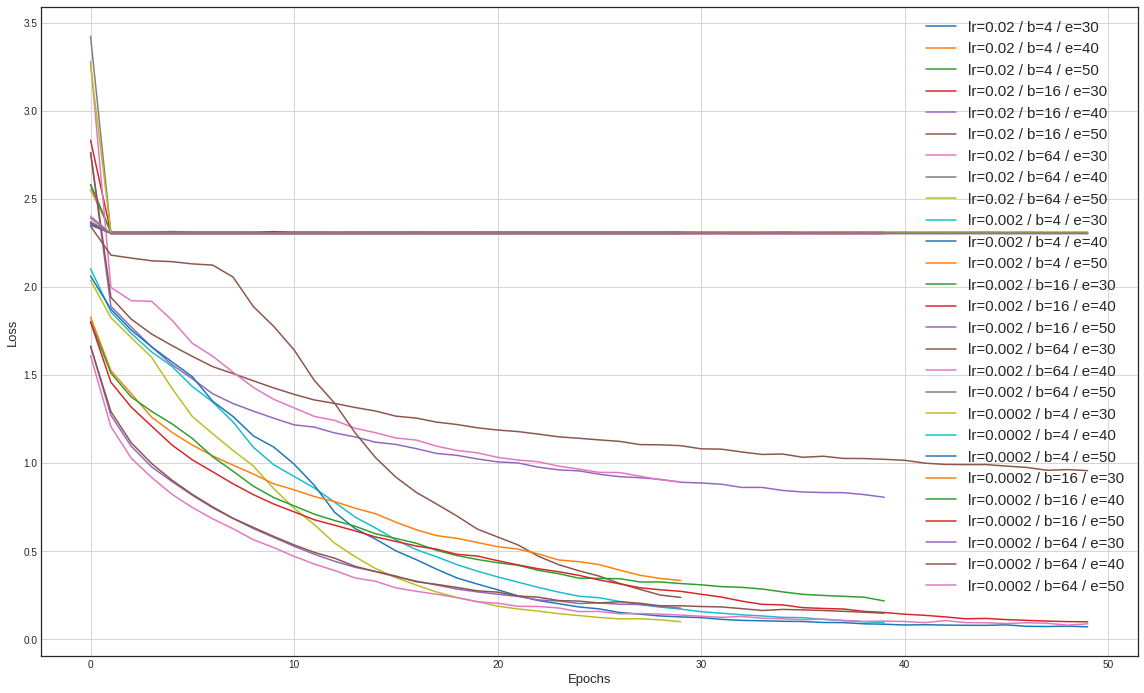

In [14]:
plt.figure(figsize=(16, 10))

for result in result_:
    lr = result['learning_rate']
    b = result['batch_size']
    e = result['epochs']
    loss_history = result['loss_history']
    label = f'lr={lr} / b={b} / e={e}'
    plt.plot(range(e), loss_history, label=label)

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.grid()
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.show()

## Learning Rate=0.02

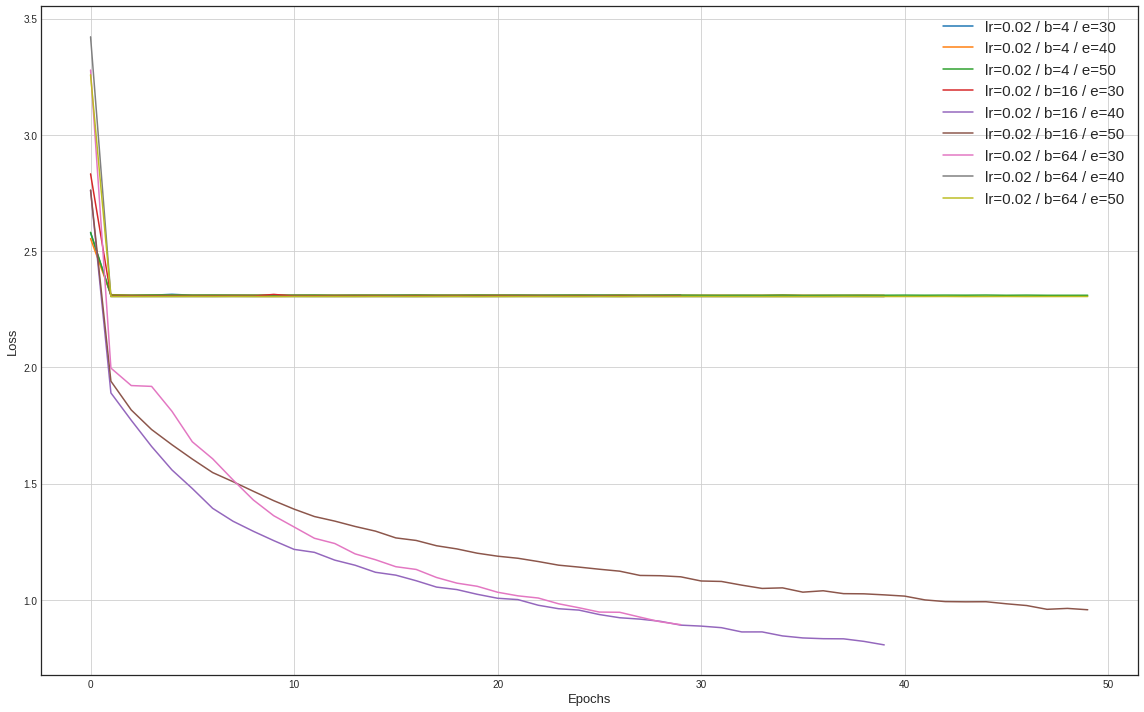

In [15]:
plt.figure(figsize=(16, 10))

for result in result_:
    lr = result['learning_rate']
    if lr != 0.02:
        continue
    b = result['batch_size']
    e = result['epochs']
    loss_history = result['loss_history']
    label = f'lr={lr} / b={b} / e={e}'
    plt.plot(range(e), loss_history, label=label)

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.grid()
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.show()

## Learning Rate=0.002

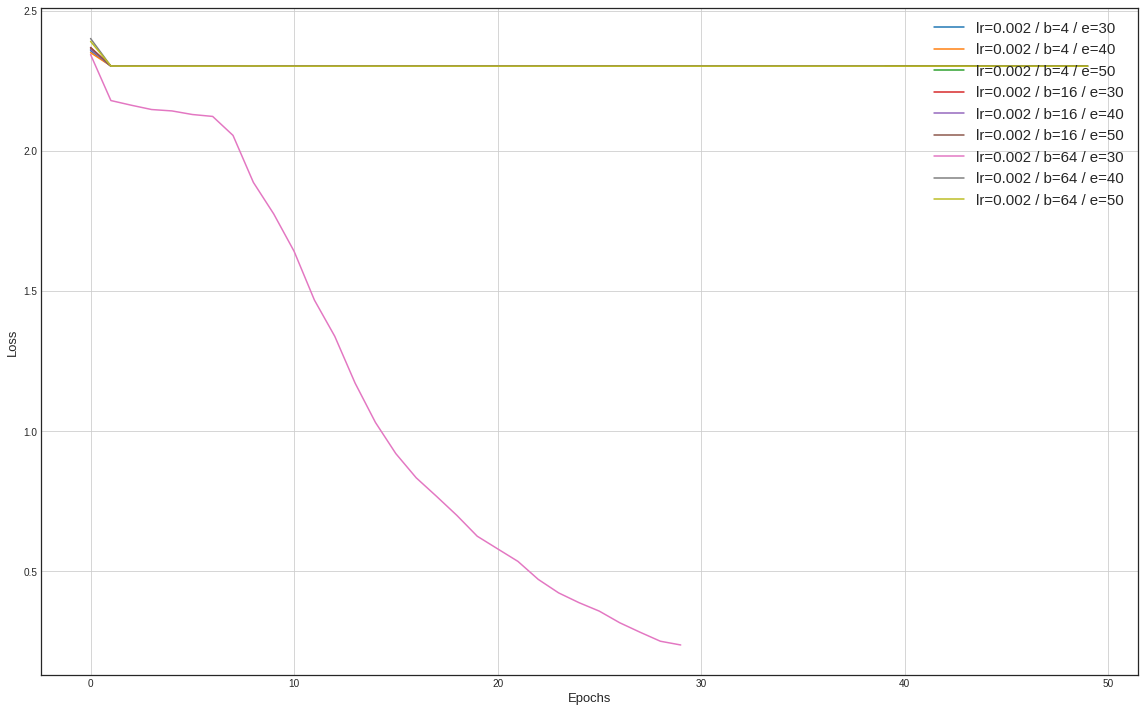

In [16]:
plt.figure(figsize=(16, 10))

for result in result_:
    lr = result['learning_rate']
    if lr != 0.002:
        continue
    b = result['batch_size']
    e = result['epochs']
    loss_history = result['loss_history']
    label = f'lr={lr} / b={b} / e={e}'
    plt.plot(range(e), loss_history, label=label)

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.grid()
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.show()

## Learning Rate=0.0002

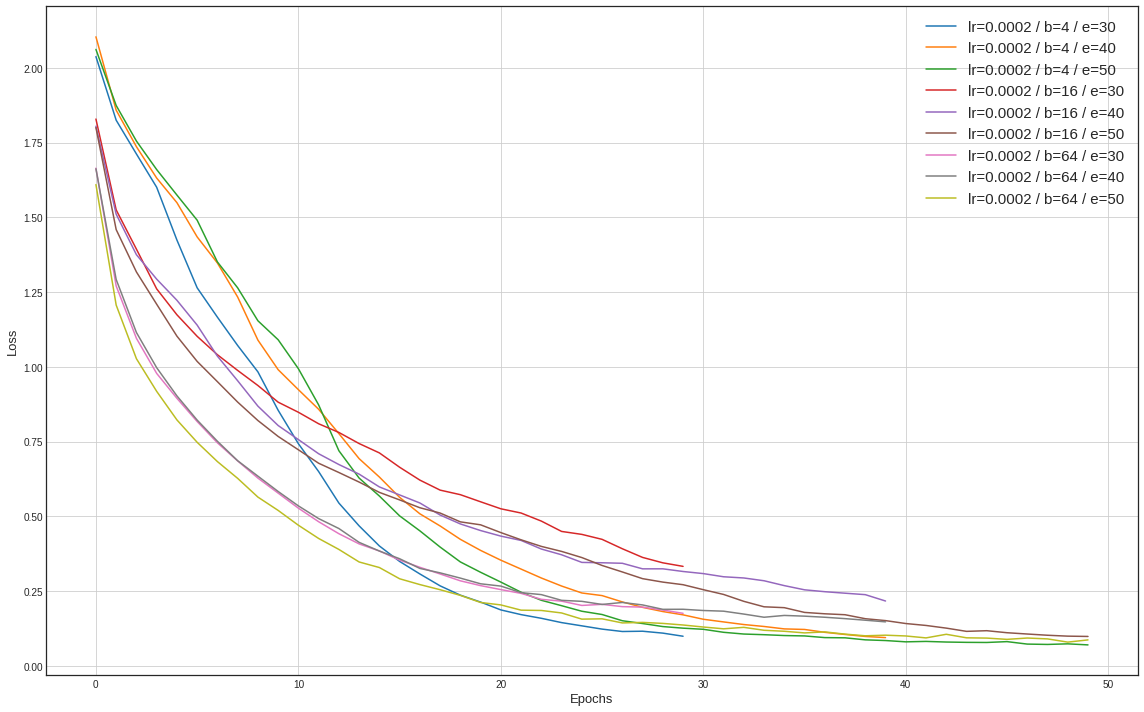

In [17]:
plt.figure(figsize=(16, 10))

for result in result_:
    lr = result['learning_rate']
    if lr != 0.0002:
        continue
    b = result['batch_size']
    e = result['epochs']
    loss_history = result['loss_history']
    label = f'lr={lr} / b={b} / e={e}'
    plt.plot(range(e), loss_history, label=label)

plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.grid()
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.show()